In [1]:
%matplotlib inline

# Time Series Practice

This note is used to practice the workflow to do time series analysis in python (especially the for the data cleaning on the timestamp).

This summary/dataset is taken based on the readings below:
* https://aeturrell.github.io/coding-for-economists/time-series.html
* https://storage.googleapis.com/dosm-public-healthcare/covid-cases.parquet

In [2]:
import pandas as pd

URL_DATA = r'https://storage.googleapis.com/dosm-public-healthcare/covid-cases.parquet'

df = pd.read_parquet(URL_DATA)
if 'date' in df.columns: df['date'] = pd.to_datetime(df['date'])

In [3]:
df = df[['date','cases_new','cases_recovered']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18496 entries, 0 to 18495
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             18496 non-null  datetime64[ns]
 1   cases_new        18496 non-null  int64         
 2   cases_recovered  18496 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 433.6 KB


In [4]:
# creating time series using pd.to_datetime method
df['date'] = pd.to_datetime(df['date'])

In [5]:
import numpy as np

# pd.to_timdelta() method ~ to create time series from scratch

test_date = pd.to_datetime('14 January 2023')
test_date += pd.to_timedelta(np.arange(12),'D')
test_date

DatetimeIndex(['2023-01-14', '2023-01-15', '2023-01-16', '2023-01-17',
               '2023-01-18', '2023-01-19', '2023-01-20', '2023-01-21',
               '2023-01-22', '2023-01-23', '2023-01-24', '2023-01-25'],
              dtype='datetime64[ns]', freq=None)

In [6]:
# or can use pd.date_range() method.

test_date = pd.date_range(start='2023/1/14', end='2023/6/14', freq='M')
test_date

DatetimeIndex(['2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30',
               '2023-05-31'],
              dtype='datetime64[ns]', freq='M')

In [7]:
# we can pass periodicity to pd.date_range method
pd.date_range('2023/1/14', periods=4, freq='D')

DatetimeIndex(['2023-01-14', '2023-01-15', '2023-01-16', '2023-01-17'], dtype='datetime64[ns]', freq='D')

In [8]:
# to format the date in case it is stored in unusual style, we can use format in the pd.to_datetime method
test_date = pd.DataFrame({"date": ["1, 19, '22", "1, 19, '23"], "values": ["1", "2"]})
test_date['date'] = pd.to_datetime(test_date['date'], format="%m, %d, '%y")
test_date

,date,values
0,2022-01-19,1
1,2023-01-19,2


In [9]:
# datetime offsets can be done using the pd.offsets method
test_date['date'] + pd.offsets.MonthEnd()

0   2022-01-31
1   2023-01-31
Name: date, dtype: datetime64[ns]

# Datetime Index

When doing time series analysis, usually we will need to set our date time as our index.

In [10]:
# This can be done using the set_index function.
test_date = test_date.set_index('date')
test_date

,values
date,
2022-01-19,1
2023-01-19,2


In [11]:
# we can use asfreq function to set the index frequency

df1 = df.set_index('date')
df1.head()

,cases_new,cases_recovered
date,,
2020-01-25,4,0
2020-01-26,0,0
2020-01-27,0,0
2020-01-28,0,0
2020-01-29,3,0


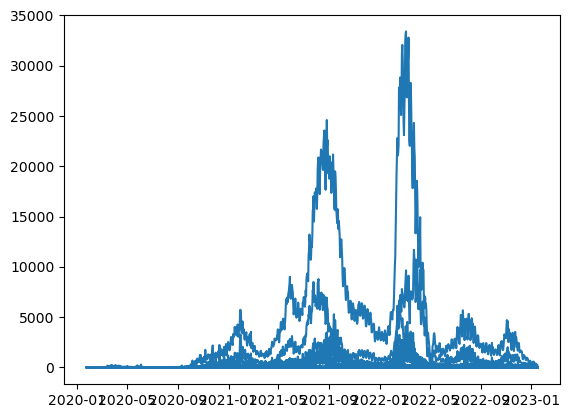

In [12]:
# after our datetime has been set as index, we can plot it.

import matplotlib.pyplot as plt

plt.plot(df1['cases_new'])

### Resampling, Rolling and Shifting

This method is sometime used when we are concern about a particular range time. For example, let say that we are a businessman which have a busy work schedule. Usually due to our limited time, we only concern about our investment's performance weekly, quaterly or even annually rather than hourly or daily. Aggregating the daily data into weekly/quaterly is already sufficient to convey the information that we want which is the performance or trend of our investment. 

In [13]:
# we can use resample to aggregate our daily case into weekly case
df2 = df1.resample('W').agg(['mean','std'])
df2.head()

cases_new           cases_recovered          
                mean       std            mean       std
date                                                    
2020-01-26  0.235294  0.955330        0.000000  0.000000
2020-02-02  0.067227  0.361988        0.000000  0.000000
2020-02-09  0.151261  0.444146        0.050420  0.219736
2020-02-16  0.084034  0.381341        0.084034  0.530108
2020-02-23  0.000000  0.000000        0.168067  0.628683

In [14]:
# if we segregate our df2 to show by day, we'll get Nan for date that is not in our df2.
df2.resample('D').asfreq().head()

cases_new          cases_recovered     
                mean      std            mean  std
date                                              
2020-01-26  0.235294  0.95533             0.0  0.0
2020-01-27       NaN      NaN             NaN  NaN
2020-01-28       NaN      NaN             NaN  NaN
2020-01-29       NaN      NaN             NaN  NaN
2020-01-30       NaN      NaN             NaN  NaN

As a remedy for the NaN data, we can either use ffill (forward fil), bfill (backward fill) or even by using interpolation. Please note that these methods is useful for time series analysis. In other analysis such as for inferential analysis (hypothesis testing), usually we'll use the mean, median or mode to replace the NaN data.

In [15]:
# replacing the Nan data in df2 using interpolation method
df2.resample('D').interpolate(method='linear', limit_direction = "forward").head()

cases_new           cases_recovered     
                mean       std            mean  std
date                                               
2020-01-26  0.235294  0.955330             0.0  0.0
2020-01-27  0.211285  0.870567             0.0  0.0
2020-01-28  0.187275  0.785804             0.0  0.0
2020-01-29  0.163265  0.701041             0.0  0.0
2020-01-30  0.139256  0.616278             0.0  0.0

In [16]:
# using rolling to aggregate the every k data into kth day.

df2 = df1.rolling(3).mean()
df2[:10]

,cases_new,cases_recovered
date,,
2020-01-25,NaN,NaN
2020-01-26,NaN,NaN
2020-01-27,1.333333,0.0
2020-01-28,0.000000,0.0
2020-01-29,1.000000,0.0
2020-01-30,1.333333,0.0
2020-01-31,1.333333,0.0
2020-02-01,0.333333,0.0
2020-02-02,0.000000,0.0


In [17]:
# we can use shift method to move our data to the left or right.

df2 = pd.DataFrame(df1['cases_new'])
df2['lead in 5 days'] = df2['cases_new'].shift(-5)
df2['lag in 3 days'] = df2['cases_new'].shift(3)
df2[:10]

,cases_new,lead in 5 days,lag in 3 days
date,,,
2020-01-25,4,1.0,NaN
2020-01-26,0,0.0,NaN
2020-01-27,0,0.0,NaN
2020-01-28,0,0.0,4.0
2020-01-29,3,0.0,0.0
2020-01-30,1,2.0,0.0
2020-01-31,0,2.0,0.0
2020-02-01,0,2.0,3.0
2020-02-02,0,1.0,1.0


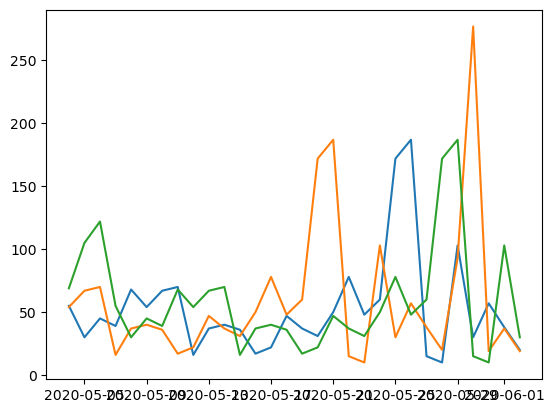

In [18]:
fig, ax = plt.subplots()
ax.plot(df2.iloc[100:130,:])

## Autocorrelation

Autocorrelation is used to check if there exist dependency between our current data point with other previous data point. The analysis of autocorrelation is a mathematical tool for finding repeating patterns

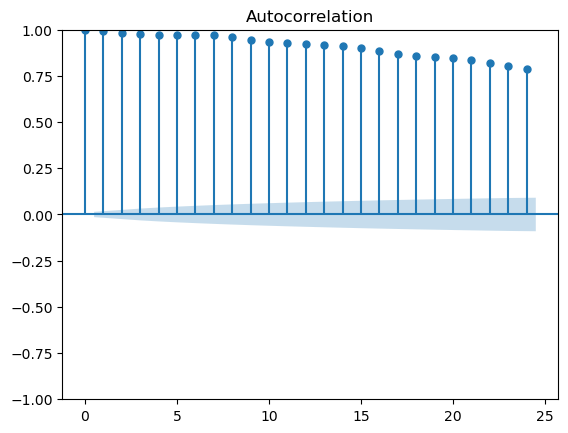

In [19]:
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(df1["cases_new"],lags=24)
plt.show()

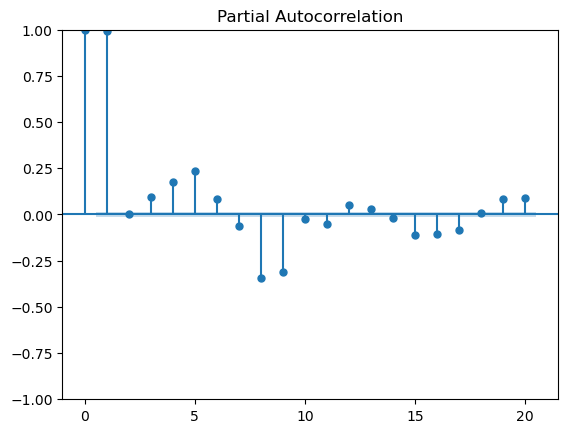

In [21]:
fig = tsaplots.plot_pacf(df1["cases_new"], lags=20, method='ywm')
plt.show()